In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [161]:
df = pd.read_csv('../data/cardio_train.csv', sep=';') # sep=';' is used to separate the data by semicolon
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# Understand the data:
- age: by days
- gender:
  - 1: women
  - 2: men
- ap_hi (Systolic blood pressure):
  - Normal: 90-119
  - Elevated: 120–139 
  - High: 140 or higher
    - The interval of ap_hi should span somewhere between 90 and 140, give or take.
- ap_lo (Diastolic blood pressure):
  - Normal: 60-79
  - Elevated: 80-89
  - High: 90 or higher
    - The interval of ap_lo should span somewhere between 60 and 90, give or take.
  - resources: https://www.cdc.gov/bloodpressure/about.htm
- cholesterol:
  - 1: normal
  - 2: above normal
  - 3: well above normal
- gluc (glucose):
  - 1: normal
  - 2: above normal
  - 3: well above normal
- smoke:
  - 0: non-smoker
  - 1: smoker
- alco (alcohol intake):
  - 0: non-drinker
  - 1: drinker
- active (physical activity):
  - 0: inactive
  - 1: active
- cardio (cardiovascular disease):
  - 0: negative
  - 1: positive

In [162]:
df.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [163]:
df.shape 

(70000, 13)

In [164]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


## a) Count the positive and negative cases for heart disease:

In [165]:
# get the count for cardio disease and no cardio disease
cardio_counts = df['cardio'].value_counts() # 0: 35021, 1: 34979

print(f'Negative cases: {cardio_counts[0]}\nPositive cases: {cardio_counts[1]}')

Negative cases: 35021
Positive cases: 34979


## b) Calculate the proportion of normal, above normal, and far above normal cholesterol levels and plot a pie chart:

In [167]:
# get the count for cholesterol
cholesterol_counts = df["cholesterol"].value_counts()

# divide the counts by the total number of rows to get the proportions
cholesterol_proportions = cholesterol_counts / len(df)

print(
    f"Normal cholesterol: {cholesterol_proportions[1]:.1%}\nAbove normal cholesterol: {cholesterol_proportions[2]:.1%}\nWell above normal cholesterol: {cholesterol_proportions[3]:.1%}"
)

Normal cholesterol: 74.8%
Above normal cholesterol: 13.6%
Well above normal cholesterol: 11.5%


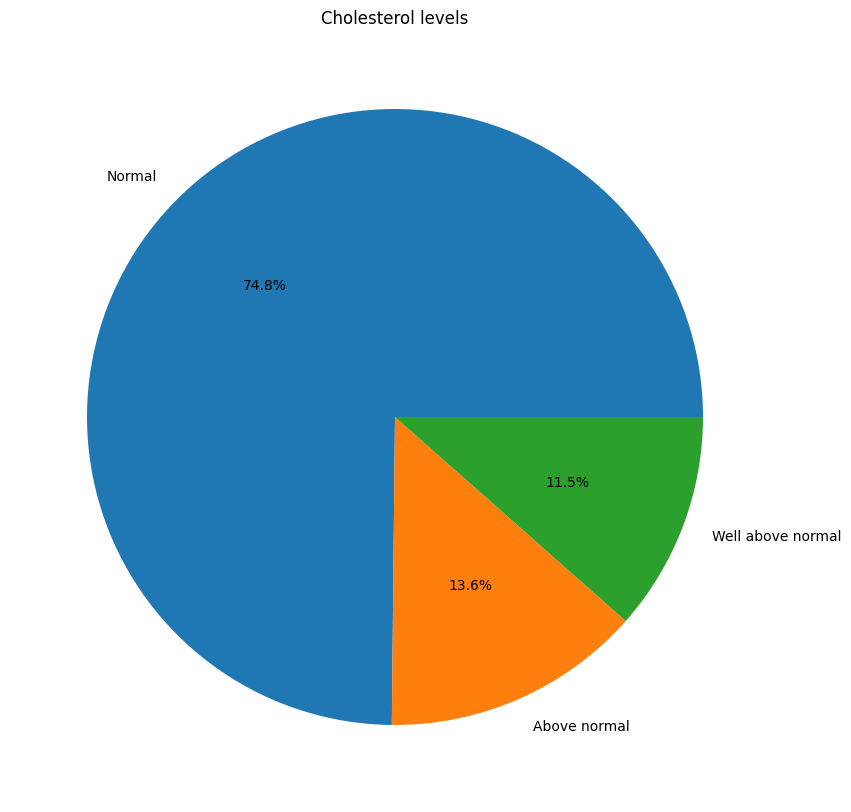

In [168]:
# pie chart for cholesterol levels

labels = ['Normal', 'Above normal', 'Well above normal'] 
plt.figure(figsize=(10, 10))
plt.pie(cholesterol_counts, labels=labels, autopct='%1.1f%%') # autopct is used to display the percentage
plt.title('Cholesterol levels')
plt.show()

## c) What does the age distribution look like? Draw a histogram.

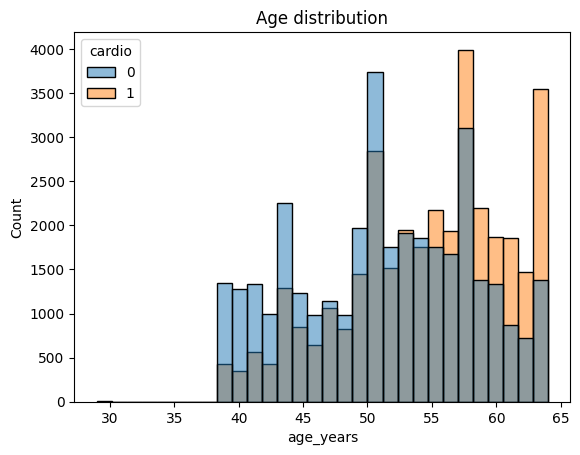

In [169]:
df['age_years'] = df['age'] // 365 # convert age from days to years, // is used to get the integer value

# Plot the age distribution
sns.histplot(data=df, x='age_years', hue='cardio', bins=30)
plt.title('Age distribution')
plt.show()

We notice that the positive cases for cardiovascular disease rises dramatically after the age of 54.

In [170]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47


## d) What proportion of the dataset are smokers?

In [171]:
# get the count for smokers and non-smokers
smoker_counts = df['smoke'].value_counts()

# divide the counts by the total number of rows to get the proportions
smoker_proportions = smoker_counts / len(df)

print(f"Non-smokers: {smoker_proportions[0]:.1%}\nSmokers: {smoker_proportions[1]:.1%}")

Non-smokers: 91.2%
Smokers: 8.8%


## e) What does the weight distribution look like? Draw an appropriate chart.

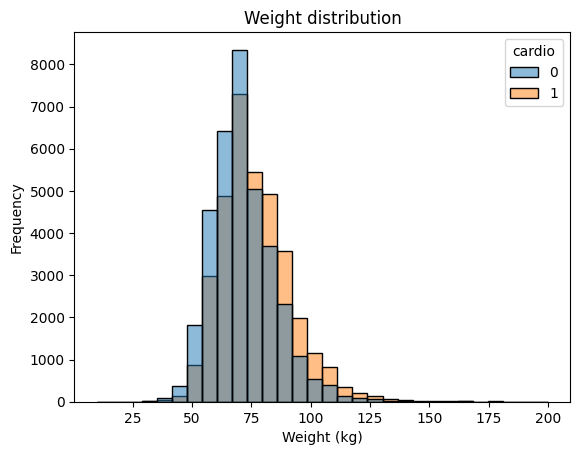

In [172]:
sns.histplot(data=df, x='weight', hue='cardio', bins=30)
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.title('Weight distribution')
plt.show()

## f) What does the height distribution look like? Draw an appropriate chart.

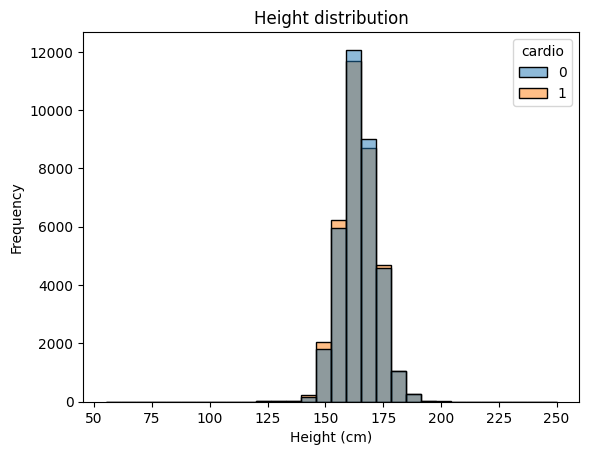

In [173]:
sns.histplot(data=df, x='height', hue='cardio', bins=30)
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.title('Height distribution')
plt.show()

## g) What proportion of women and men have cardiovascular disease? Draw an appropriate chart.

In [174]:
# Calculate the proportion of women and men with cardiovascular disease
gender_cardio_proportion = df.groupby('gender')['cardio'].mean()

print(f"Proportion of women with cardiovascular disease: {gender_cardio_proportion[1]:.4f}")
print(f"Proportion of men with cardiovascular disease: {gender_cardio_proportion[2]:.4f}")

Proportion of women with cardiovascular disease: 0.4967
Proportion of men with cardiovascular disease: 0.5052


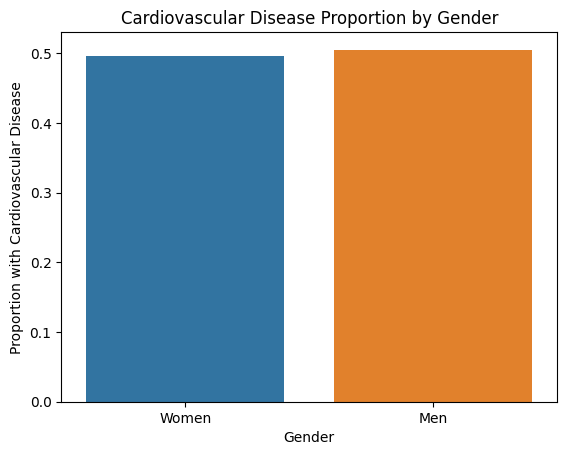

In [179]:
sns.barplot(x=['Women', 'Men'], y=gender_cardio_proportion.values)
plt.xlabel('Gender')
plt.ylabel('Proportion with Cardiovascular Disease')
plt.title('Cardiovascular Disease Proportion by Gender')
plt.show()